# This is my second attempt at creating a model using sklearn alogithms
This time we'll be breaking out the neighborhoods and seeing if that has any affect on how well our algorithms do. We're working on Note #3 from my last notebook: https://github.com/rileyrustad/CLCrawler/blob/master/First_Analysis.ipynb

Originally I had thought to create a price multiplier based on how much higher entries were than the average, and then average that multiplier with the n closest neighbors, but computationally it's really espensive. I may explore that next time.

Now we'll be using K-means clustering to cluster neighborhoods

In [2]:
# start with imports
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load the data from our JSON file. 
The data is stored as a dictionary of dictionaries in the json file. We store it that way beacause it's easy to add data to the existing master data file. Also, I haven't figured out how to get it in a database yet.

In [3]:
with open('/Users/mac28/CLCrawler/MasterApartmentData.json') as f:
    my_dict = json.load(f)
dframe = DataFrame(my_dict)

dframe = dframe.T
dframe.head()

,bath,bed,cat,content,date,dog,feet,getphotos,hasmap,housingtype,lat,laundry,long,parking,price,smoking,time,wheelchair
5399866740,1,1,0,754,2016-01-12,0,750,8,0,apartment,NaN,w/d in unit,NaN,off-street parking,1400,NaN,12:22:07,NaN
5401772970,1,1,1,2632,2016-01-13,1,659,7,1,apartment,45.531,w/d in unit,-122.664,attached garage,1350,no smoking,16:24:11,wheelchair accessible
5402562933,1.5,NaN,0,1001,2016-01-14,0,1,2,1,apartment,45.5333,laundry on site,-122.709,carport,1500,no smoking,09:12:40,NaN
5402607488,1,2,0,2259,2016-01-14,0,936,12,1,condo,45.5328,w/d in unit,-122.699,attached garage,1995,NaN,09:36:16,NaN
5402822514,1,1,0,1110,2016-01-14,0,624,16,1,apartment,45.5053,w/d in unit,-122.618,street parking,1495,NaN,11:31:03,NaN


## Clean up the data a bit
Right now the 'shared' and 'split' are included in number of bathrooms. If I were to convert that to a number I would consider a shared/split bathroom to be half or 0.5 of a bathroom.

In [4]:
dframe.bath = dframe.bath.replace('shared',0.5)
dframe.bath = dframe.bath.replace('split',0.5)

## Get rid of null values
I haven't figured out the best way to clean this up yet. For now I'm going to drop any rows that have a null value, though I recognize that this is not a good analysis practice. We ended up dropping ~15% of data points. 

😬

Also there were some CRAZY outliers, and this analysis is focused on finding a model for apartments for the 99% of us that can't afford crazy extravigant apartments

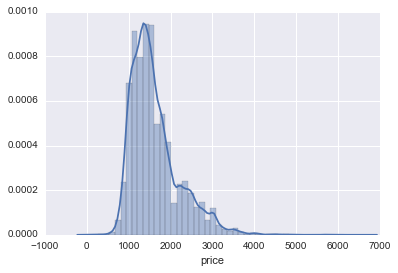

In [5]:
df = dframe[dframe.price < 10000][['bath','bed','feet','price']].dropna()
sns.distplot(df.price)

/Users/mac28/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


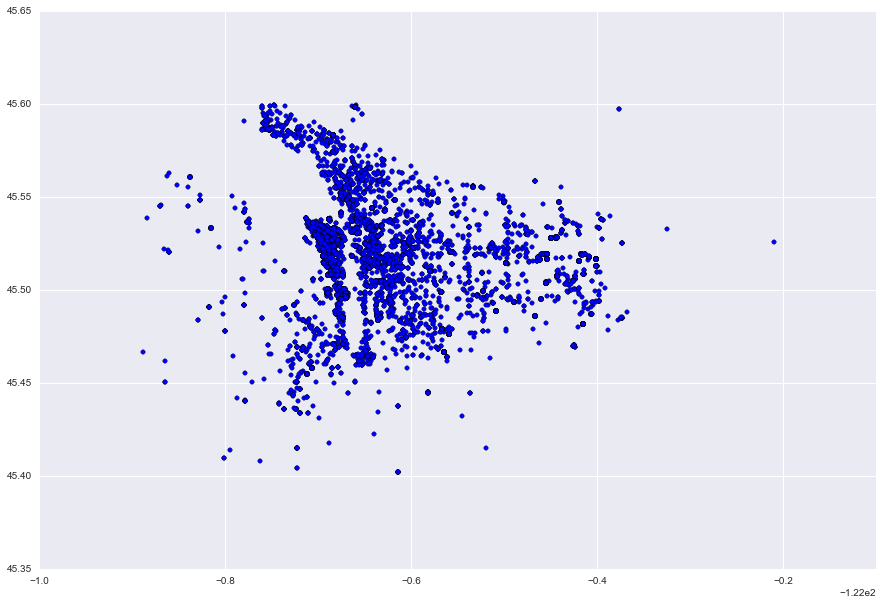

In [6]:
data = dframe[dframe.lat > 45.4][dframe.lat < 45.6][dframe.long < -122.0][dframe.long > -123.5]
plt.figure(figsize=(15,10))
plt.scatter(data = data, x = 'long',y='lat')


### It looks like Portland!!!
Let's cluster the data. Start by creating a list of [['lat','long'], ...]

In [7]:
XYdf = dframe[dframe.lat > 45.4][dframe.lat < 45.6][dframe.long < -122.0][dframe.long > -123.5]
data = [[XYdf['lat'][i],XYdf['long'][i]] for i in XYdf.index]



We'll use K Means Clustering because that's the clustering method I recently learned in class! There may be others that work better, but this is the tool that I know

In [8]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=11)
km.fit(data)
neighborhoods = km.cluster_centers_
neighborhoods


array([[  45.52817788, -122.69051011],
       [  45.51157403, -122.43280767],
       [  45.48636113, -122.63293877],
       [  45.49598004, -122.57206021],
       [  45.52899313, -122.81465686],
       [  45.46020617, -122.71708223],
       [  45.50438996, -122.68064364],
       [  45.51572691, -122.50855278],
       [  45.5643463 , -122.67007143],
       [  45.52665197, -122.63869456],
       [  45.58653763, -122.74009838]])

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


'Note to Riley: come back and make it look pretty'

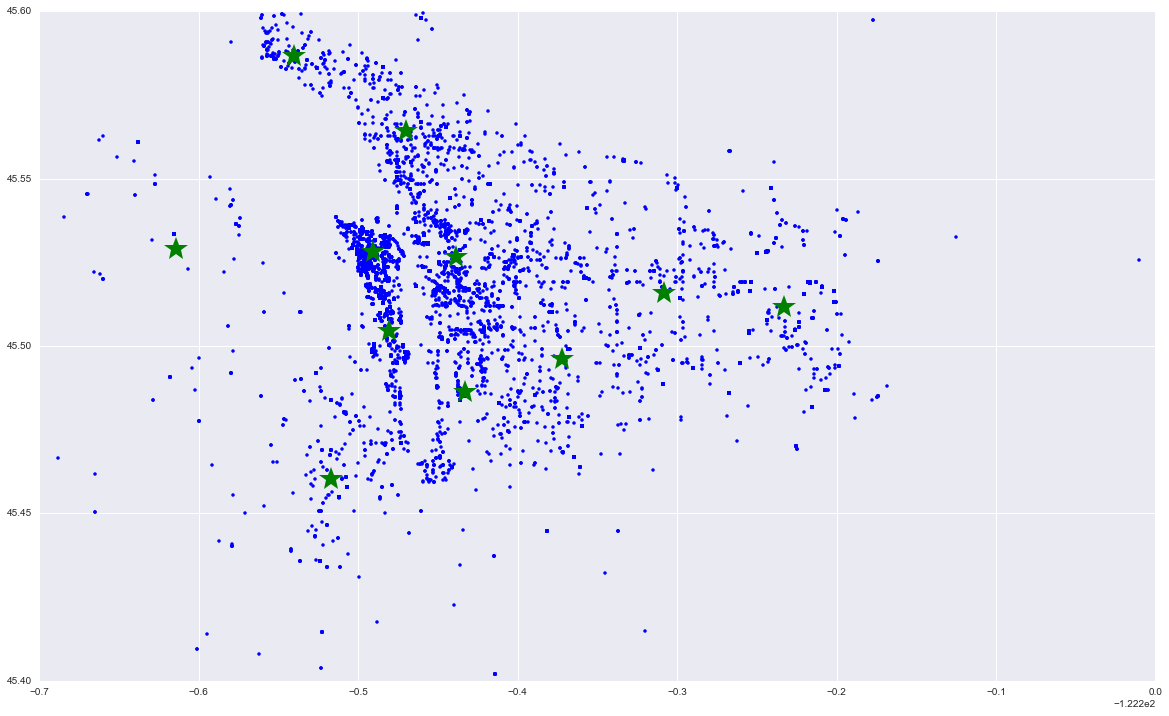

In [9]:
%pylab inline
figure(1,figsize=(20,12))
plot([row[1] for row in data],[row[0] for row in data],'b.')
for i in km.cluster_centers_:  
    plot(i[1],i[0], 'g*',ms=25)
'''Note to Riley: come back and make it look pretty'''

### We chose our neighborhoods!
I've found that every once in a while the centers end up in different points, but are fairly consistant. Now let's process our data points and figure out where the closest neighborhood center is to it!

In [10]:
neighborhoods = neighborhoods.tolist()
for i in enumerate(neighborhoods):
    i[1].append(i[0])
print neighborhoods

[[45.52817787863929, -122.69051011277965, 0], [45.511574029392555, -122.43280766949707, 1], [45.486361130136984, -122.6329387694064, 2], [45.49598004144283, -122.57206021028396, 3], [45.52899313125, -122.81465685625, 4], [45.46020617045455, -122.71708222727273, 5], [45.50438996186916, -122.68064364149532, 6], [45.515726905956114, -122.50855277899687, 7], [45.5643462981607, -122.6700714269119, 8], [45.526651966148215, -122.63869456084171, 9], [45.58653763453815, -122.74009837751004, 10]]


Create a function that will label each point with a number coresponding to it's neighborhood

In [11]:
def clusterer(X, Y,neighborhoods):
    neighbors = []
    for i in neighborhoods:
        distance = ((i[0]-X)**2 + (i[1]-Y)**2)
        neighbors.append(distance)
    closest = min(neighbors)
    return neighbors.index(closest)

In [12]:
neighborhoodlist = []
for i in dframe.index:
    neighborhoodlist.append(clusterer(dframe['lat'][i],dframe['long'][i],neighborhoods))
neighborhoodlist[:5]

[0, 9, 0, 0, 2]

In [13]:
dframe['neighborhood'] = Series((neighborhoodlist), index=dframe.index)
dframe.head()

,bath,bed,cat,content,date,dog,feet,getphotos,hasmap,housingtype,lat,laundry,long,parking,price,smoking,time,wheelchair,neighborhood
5399866740,1,1,0,754,2016-01-12,0,750,8,0,apartment,NaN,w/d in unit,NaN,off-street parking,1400,NaN,12:22:07,NaN,0
5401772970,1,1,1,2632,2016-01-13,1,659,7,1,apartment,45.531,w/d in unit,-122.664,attached garage,1350,no smoking,16:24:11,wheelchair accessible,9
5402562933,1.5,NaN,0,1001,2016-01-14,0,1,2,1,apartment,45.5333,laundry on site,-122.709,carport,1500,no smoking,09:12:40,NaN,0
5402607488,1,2,0,2259,2016-01-14,0,936,12,1,condo,45.5328,w/d in unit,-122.699,attached garage,1995,NaN,09:36:16,NaN,0
5402822514,1,1,0,1110,2016-01-14,0,624,16,1,apartment,45.5053,w/d in unit,-122.618,street parking,1495,NaN,11:31:03,NaN,2


### Split data into Training and Testing Data
We're selecting variables now. So far I haven't been able to figure out how to feed in discrete variables. It seems to handle continuous variables just fine. The neighborhood variable is encoded, so I'm assuming that it's being interpreted like a continuous variable. 

The Sci-Kit Learn documentation says that it can handle both kinds of variables, but I've found a few other discussion forums that say that they do not, to create a separate feature for each type of varaible... Fun. Someone mentioned one hot encoder.

That will likely be the next iteration of my analysis, but I'm just not there yet.

... Also need to figure out what to do with my missing data... I'm dropping ~15% right now because I'm dropping all of the null values

In [14]:
from __future__ import division
print len(dframe)
df2 = dframe[dframe.price < 10000][['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'price','neighborhood']].dropna()
print len(df2)
print len(df2)/len(dframe)
features = df2[['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'neighborhood']].values
price = df2[['price']].values
from sklearn.cross_validation import train_test_split
features_train, features_test, price_train, price_test = train_test_split(features, price, test_size=0.1, random_state=42)

15375
12974
0.843837398374


Ok, lets put it through Decision Tree!

In [15]:
from sklearn import tree
from sklearn.metrics import r2_score

In [16]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(features_train, price_train)

In [17]:
pred = np.array([[item] for item in clf.predict(features_test)])

0.827861188601


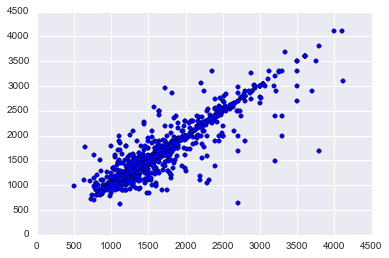

In [18]:
print r2_score(pred, price_test)
plt.scatter(pred,price_test)

## .78 Woot!
That's better than our Decision Trees last time! Clearly even with the neighborhood being interpreted as a continuous varaible, It's still helping!

## What about Random Forest?

In [19]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg = reg.fit(features_train, price_train)


/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [20]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

0.866315812408


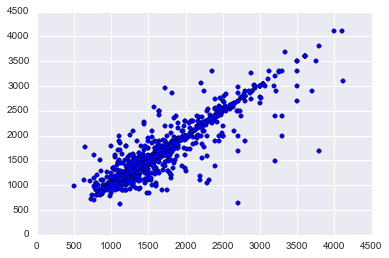

In [21]:
print r2_score(forest_pred, price_test)
plt.scatter(pred,price_test)

Wow! up to .85! That's our best yet! What if we add more trees???

In [22]:
reg = RandomForestRegressor(n_estimators = 100)
reg = reg.fit(features_train, price_train)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [23]:
forest_pred = reg.predict(features_test)
forest_pred = np.array([[item] for item in forest_pred])

0.873578687602


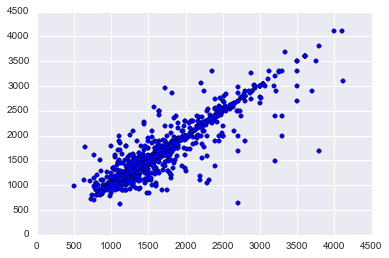

In [24]:
print r2_score(forest_pred, price_test)
print plt.scatter(pred,price_test)

Up to .87!

So what is our goal now? I'd like to see if adjusting the number of neighborhoods increases the accuracy. same for the affect with the number of trees

In [25]:
def neighborhood_optimizer(dframe,neighborhood_number_range, counter_num):
    XYdf = dframe[dframe.lat > 45.4][dframe.lat < 45.6][dframe.long < -122.0][dframe.long > -123.5]
    data = [[XYdf['lat'][i],XYdf['long'][i]] for i in XYdf.index]
    r2_dict = []
    for i in neighborhood_number_range:
        counter = counter_num
        average_accuracy_list = []
        while counter > 0:
            km = KMeans(n_clusters=i)
            km.fit(data)
            neighborhoods = km.cluster_centers_
            neighborhoods = neighborhoods.tolist()
            for x in enumerate(neighborhoods):
                x[1].append(x[0])
            neighborhoodlist = []
            for z in dframe.index:
                neighborhoodlist.append(clusterer(dframe['lat'][z],dframe['long'][z],neighborhoods))
            dframecopy = dframe.copy()
            dframecopy['neighborhood'] = Series((neighborhoodlist), index=dframe.index)
            df2 = dframecopy[dframe.price < 10000][['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'price','neighborhood']].dropna()
            features = df2[['bath','bed','feet','dog','cat','content','getphotos', 'hasmap', 'neighborhood']].values
            price = df2[['price']].values
            features_train, features_test, price_train, price_test = train_test_split(features, price, test_size=0.1)
            reg = RandomForestRegressor()
            reg = reg.fit(features_train, price_train)
            forest_pred = reg.predict(features_test)
            forest_pred = np.array([[item] for item in forest_pred])
            counter -= 1
            average_accuracy_list.append(r2_score(forest_pred, price_test))
        total = 0
        for entry in average_accuracy_list:
            total += entry
        r2_accuracy = total/len(average_accuracy_list)
        r2_dict.append((i,r2_accuracy))
    print r2_dict
    return r2_dict

In [26]:
neighborhood_number_range = [i for _,i in enumerate(range(2,31,2))]
neighborhood_number_range

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [27]:
r2_dict = neighborhood_optimizer(dframe,neighborhood_number_range,10)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: 

[(2, 0.8062243181314287), (4, 0.8189642518984579), (6, 0.83614475016967948), (8, 0.86271306622075861), (10, 0.85873915283754398), (12, 0.84725660702413719), (14, 0.85464021182401395), (16, 0.86229449783952372), (18, 0.85840402555237749), (20, 0.84041711693957288), (22, 0.85559890486573165), (24, 0.8505056129429367), (26, 0.8488687598977156), (28, 0.8393287906826894), (30, 0.85641476129377891)]


In [28]:
r2_dict[:][0]

(2, 0.8062243181314287)

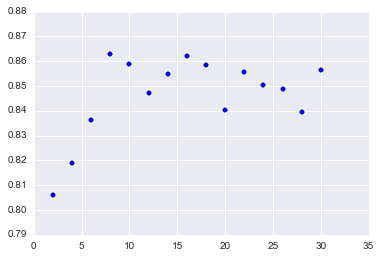

In [29]:
plt.scatter([x[0] for x in r2_dict],[x[1] for x in r2_dict])

Looks like the optimum is right around 10 or 11, and then starts to drop off. Let's get a little more granular and look at a smaller range

In [30]:
neighborhood_number_range = [i for _,i in enumerate(range(7,15))]
neighborhood_number_range

[7, 8, 9, 10, 11, 12, 13, 14]

In [31]:
r2_dict = neighborhood_optimizer(dframe,neighborhood_number_range,10)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: 

[(7, 0.84960750272316399), (8, 0.86463138122943251), (9, 0.85242992565413067), (10, 0.86743372488178017), (11, 0.85759727058286794), (12, 0.86352210203458457), (13, 0.86030511494711082), (14, 0.85254154452277986)]


[(7, 0.84960750272316399), (8, 0.86463138122943251), (9, 0.85242992565413067), (10, 0.86743372488178017), (11, 0.85759727058286794), (12, 0.86352210203458457), (13, 0.86030511494711082), (14, 0.85254154452277986)]


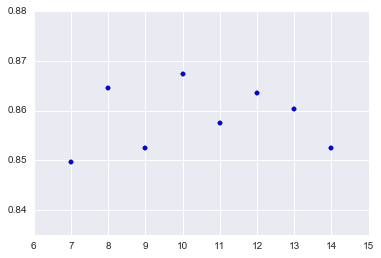

In [32]:
print r2_dict
plt.scatter([x[0] for x in r2_dict],[x[1] for x in r2_dict])

Trying a few times, it looks like 10, 11 and 12 get the best results at ~.85. Of course, we'll need to redo some of these optomizations after we properly process our data. Hopefully we'll see some more consistency then too.

In [33]:
r2_dict = neighborhood_optimizer(dframe,[10,11,12],25)

/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: 

[(10, 0.85867186972496112), (11, 0.85939514740874645), (12, 0.86139935282475377)]


/Users/mac28/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Note #1 to Riley: (From Last time) Perhaps look into another regressor? see if there's one that's inherantly better at this kind of thing.

Note #2 to Riley: Figure out how to process data so that you don't have to drop null values

Note #3 to Riley: convert categorical data into binary

Note #4 to Riley: I wonder if increasing the number of neighborhoods would become more accurate as we collect more data? like you could create a bunch of little accurate models instead of a bunch of bigger ones.

Learned: If you plan on using Decision Tree/Random Forest from SKLearn, make sure you collect your discrete variables in separate columns and make them binary yes or no(0 or 1).